# CHESS TITLE ANALYSIS

In this project I will analyze some chess ELO data, and try to predict which Title a player holds based on their ELO.
For this the plan is to use a Unsupervised learning approach. In this case KMeans Clustering.


We have 3 Ratings (1500-3000 and a Title [FM, GM, IM]), based on the 3 Ratings we want to predict the Title. 

## EDA

### Inital Code to load the Data

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sql
import numpy as np
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 


In [38]:
db2 = "fide_ranking.sqlite"
db = "fideDB.sqlite"


In [39]:
def connect(db):
    return sql.connect(db)
    
def close(con):
    con.close()
    
query1 = """
    SELECT * 
    FROM fide;
    """

query2 = """
    SELECT * 
    FROM Fide_1600;
    """
query3 = """
    SELECT * 
    FROM Fide_1700;
    """
query4 = """
    SELECT * 
    FROM Fide_bundes;
    """
query5 = """
    SELECT * 
    FROM Fide_ranking;
    """

In [40]:
con = connect(db)
data1 = pd.read_sql(query1, con)
con2 = connect(db2)
data2 = pd.read_sql(query2, con2)
data3 = pd.read_sql(query3, con2)
data4 = pd.read_sql(query4, con2)
data5 = pd.read_sql(query5, con2)
close(con)
close(con2)
data1

,level_0,index,title,name,FIDE,bullet,blitz,Chess960,Rapid,UltraBullet,...,King,Racing,Antichess,Three-check,Crazyhouse,Correspondence,Horde,username,bullet_rd,blitz_rd
0,0,0,FM,Umut Erdem Gündüz,2340,2738,2472,None,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
1,1,1,FM,Abubaker Tagelsir 12200875,2219,2245,2468,1876,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
2,2,2,IM,Matvey Galchenko,2453,2968,2819,None,2643,2395,...,None,None,None,None,None,None,None,None,NaN,NaN
3,3,3,FM,Nikhil Dixit,2331,2581,2516,1933,None,None,...,None,None,None,None,None,None,None,None,NaN,NaN
4,4,4,FM,Mohamed Elsayed,2212,2198,2326,None,2115,None,...,None,None,None,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,995,995,None,None,None,1837.0,1976.0,None,None,None,...,None,None,None,None,None,None,None,wildcat77,45.0,45.0
5288,996,996,None,None,None,1668.0,1913.0,None,None,None,...,None,None,None,None,None,None,None,Ybalogs,45.0,45.0
5289,997,997,None,None,None,1751.0,2069.0,None,None,None,...,None,None,None,None,None,None,None,yogi2017,135.0,135.0
5290,998,998,None,None,None,1910.0,1881.0,None,None,None,...,None,None,None,None,None,None,None,zeb4547,45.0,45.0


As we only care about title, FIDE, bullet and blitz lets filter it out.

In [41]:
def trans(data):
    try:
        df = data[["title", "FIDE", "blitz", "bullet"]]
    except:
        df = data[["FIDE", "blitz", "bullet"]]
    df2 = pd.DataFrame({"FIDE": 0, "blitz": 0, "bullet": 0}, index=[0])
    df = pd.concat([df,df2])
    df2 = pd.DataFrame({"FIDE": 3500, "blitz": 3500, "bullet": 3500}, index=[0])
    df = pd.concat([df,df2]).reset_index()
    return df

In [42]:
data11 = trans(data1)
data22 = trans(data2)
data33 = trans(data3)
data44 = trans(data4)
data55 = trans(data5)
data11

,index,title,FIDE,blitz,bullet
0,0,FM,2340,2472,2738
1,1,FM,2219,2468,2245
2,2,IM,2453,2819,2968
3,3,FM,2331,2516,2581
4,4,FM,2212,2326,2198
...,...,...,...,...,...
5289,5289,None,None,2069.0,1751.0
5290,5290,None,None,1881.0,1910.0
5291,5291,None,None,1637.0,1862.0
5292,0,NaN,0,0,0


Let's remove all the NaNs and more. 

In [43]:
df  = pd.concat([data11,data22,data33,data44,data55])
df = df[["title","FIDE","blitz","bullet"]]
df = df.drop_duplicates()
df = df.dropna()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426 entries, 0 to 394
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1426 non-null   object
 1   FIDE    1426 non-null   object
 2   blitz   1426 non-null   object
 3   bullet  1426 non-null   object
dtypes: object(4)
memory usage: 55.7+ KB


We need to convert all the data into a uniform format. 

In [45]:
warnings.simplefilter('ignore')

df_filtered = df[df['title'].isin(['NM', 'IM', 'GM'])]

df_filtered['FIDE'] = pd.to_numeric(df_filtered['FIDE'])
df_filtered['blitz'] = pd.to_numeric(df_filtered['blitz'])
df_filtered['bullet'] = pd.to_numeric(df_filtered['bullet'])


df_filtered['FIDE'] = df_filtered['FIDE'].round().astype(int)
df_filtered['blitz'] = df_filtered['blitz'].round().astype(int)
df_filtered['bullet'] = df_filtered['bullet'].round().astype(int)

In [46]:
df_filtered.title.value_counts()

IM    338
GM    234
NM    104
Name: title, dtype: int64

In [47]:
df_filtered = df_filtered[df_filtered['FIDE'] >= 1800]

In [48]:
df_filtered = df_filtered.reset_index(drop=True)

So let's see how the data actually looks. 

In [49]:
df_filtered

,title,FIDE,blitz,bullet
0,IM,2453,2819,2968
1,NM,2375,2659,2662
2,IM,2376,2595,2431
3,GM,2680,2728,2512
4,IM,2443,2563,2640
...,...,...,...,...
667,NM,2100,2344,2431
668,NM,2106,2216,1913
669,NM,2126,2276,2259
670,NM,2119,2310,2203


### Initial Plots

Let's take a look how the Data actual looks. This will include the labels we already know (these won't be used for the training later), but it gives us an idea of what Clusters we need to build. 

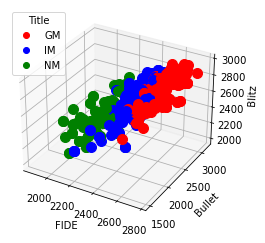

In [50]:
colors = {'GM': 'red', 'IM': 'blue', 'NM': 'green'}

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(df_filtered)):
    row = df_filtered.iloc[i]
    ax.scatter(row['FIDE'], row['bullet'], row['blitz'], c=colors[row['title']], s=100)
ax.set_xlabel('FIDE')
ax.set_ylabel('Bullet')
ax.set_zlabel('Blitz')


handles = [plt.plot([], [], marker='o', ls="", color=color, label=title)[0] for title, color in colors.items()]
ax.legend(handles=handles, title='Title', loc='upper left')

# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
# How to get the legend with the colors

plt.show()

We can see 3 distinct sections, so let's try and build a KMeans and see where we are at. We will just do 5 clusters to start.

In [51]:
kmeans = KMeans(n_clusters=5)

kmeans.fit(df_filtered[["FIDE", "blitz", "bullet"]])

df_filtered['pred_title'] = kmeans.labels_
df_filtered['pred_title'] = df_filtered['pred_title']

In [52]:
df_filtered

,title,FIDE,blitz,bullet,pred_title
0,IM,2453,2819,2968,1
1,NM,2375,2659,2662,3
2,IM,2376,2595,2431,0
3,GM,2680,2728,2512,3
4,IM,2443,2563,2640,3
...,...,...,...,...,...
667,NM,2100,2344,2431,2
668,NM,2106,2216,1913,2
669,NM,2126,2276,2259,2
670,NM,2119,2310,2203,2


We can see we now have a pred_title column which gives a label for the title. These are not mapped yet. To find out the mapping we are using cross tab and some logic. 


In [53]:
df_test = df_filtered.copy()

In [54]:
cross_tab = pd.crosstab(df_test['pred_title'], df_test['title'])
cross_tab

title,GM,IM,NM
pred_title,,,
0,22,101,20
1,119,68,0
2,0,11,62
3,92,150,18
4,1,8,0


In [55]:
test = cross_tab.divide(cross_tab.sum(axis=1), axis=0)
test

title,GM,IM,NM
pred_title,,,
0,0.153846,0.706294,0.139860
1,0.636364,0.363636,0.000000
2,0.000000,0.150685,0.849315
3,0.353846,0.576923,0.069231
4,0.111111,0.888889,0.000000


If GM,IM or NM are more than 60% then I assign the label as mapped. 

In [56]:
result = test.idxmax(axis=1)
result[test.max(axis=1) < 0.6] = None
result = result.dropna()
mapping = result.to_dict()
mapping


{0: 'IM', 1: 'GM', 2: 'NM', 4: 'IM'}

Now we can apply our mapping and get our accuracy. 

In [57]:
df_test['pred_title'] = df_test['pred_title'].map(mapping)
df_test = df_test.dropna()
df_test

,title,FIDE,blitz,bullet,pred_title
0,IM,2453,2819,2968,GM
2,IM,2376,2595,2431,IM
5,GM,2536,2848,2713,GM
7,NM,2001,2273,2331,NM
9,GM,2602,2814,2801,GM
...,...,...,...,...,...
667,NM,2100,2344,2431,NM
668,NM,2106,2216,1913,NM
669,NM,2126,2276,2259,NM
670,NM,2119,2310,2203,NM


In [58]:
accuracy = accuracy_score(df_test['pred_title'], df_test['title'])
accuracy

0.7038834951456311

An accuracy of 70% is not great and we would want to improve this significantly. To do this we will adjust our Hyperparameters.

### Automating Hyperparameter finding

To find the best Hyperparameters I will create a function which tests various combinations to find a good balance. 
The following function just does what we done above, but makes it into a function where we control the parameters. 

In [59]:
def train(df, n=3, i=300, init="k-means++"):
    data = df.copy()
    kmeans = KMeans(n_clusters=n, max_iter=i, init=init)

    kmeans.fit(data[["FIDE", "blitz", "bullet"]])

    data['pred_title'] = kmeans.labels_
    data['pred_title'] = data['pred_title']
    cross_tab = pd.crosstab(data['pred_title'], data['title'])
    
    test = cross_tab.divide(cross_tab.sum(axis=1), axis=0)
    result = test.idxmax(axis=1)
    result[test.max(axis=1) < 0.6] = None
    result = result.dropna()
    mapping = result.to_dict()
    data['pred_title'] = data['pred_title'].map(mapping)
    data = data.dropna()
    accuracy = accuracy_score(data['pred_title'], data['title'])
    return accuracy, data, kmeans

Here is the output of our function if we have n=3 (Cluster Size) and i=100 (max_iterations).
These are in my opinion the two most important parameters for k means clustering in scikitlearn. 

In [60]:
a, d, m = train(df_filtered, n=3, i=100)
a,d,m

(0.7142857142857143,
     title  FIDE  blitz  bullet pred_title
 1      NM  2375   2659    2662         IM
 2      IM  2376   2595    2431         IM
 4      IM  2443   2563    2640         IM
 6      IM  2410   2629    2626         IM
 7      NM  2001   2273    2331         NM
 ..    ...   ...    ...     ...        ...
 667    NM  2100   2344    2431         NM
 668    NM  2106   2216    1913         NM
 669    NM  2126   2276    2259         NM
 670    NM  2119   2310    2203         NM
 671    NM  1988   2205    2064         NM
 
 [371 rows x 5 columns],
 KMeans(max_iter=100, n_clusters=3))

Let's visualize this one 

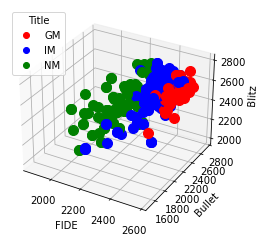

In [61]:
colors = {'GM': 'red', 'IM': 'blue', 'NM': 'green'}

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(d)):
    row = d.iloc[i]
    ax.scatter(row['FIDE'], row['bullet'], row['blitz'], c=colors[row['title']], s=100)
ax.set_xlabel('FIDE')
ax.set_ylabel('Bullet')
ax.set_zlabel('Blitz')


handles = [plt.plot([], [], marker='o', ls="", color=color, label=title)[0] for title, color in colors.items()]
ax.legend(handles=handles, title='Title', loc='upper left')

# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
# How to get the legend with the colors

plt.show()

#### with 3 clusters we can see it goes in the right direction, but we don't we see a lof mixing here. We should try more clusters and see how it progresses, but lets automate this search. 

So, onto automation. 

In [62]:
results = []

In [63]:
list_n = list(range(3,15))
list_i = list(range(200,1500,100))

beste = None
top_score = 0
results = []
for n in list_n:
    for i in list_i:
        best = train(df_filtered, n=n, i=i)
        score = best[0]
        if score > top_score:
            top_score = score
            beste = best
        results.append((n, i, score))
        
df = pd.DataFrame(results, columns=['n', 'i', 'score'])
pivot_table = df.pivot(index='n', columns='i', values='score')
pivot_table.head()

i,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400
n,,,,,,,,,,,,,
3,0.714286,0.714286,0.714286,0.714286,0.714286,0.712366,0.714286,0.714286,0.714286,0.712366,0.714286,0.714286,0.714286
4,0.625000,0.631707,0.625000,0.625000,0.625000,0.631707,0.636139,0.637037,0.636364,0.625000,0.634568,0.634568,0.625000
5,0.719626,0.707317,0.707317,0.703883,0.703883,0.707317,0.703883,0.703883,0.703883,0.703883,0.703883,0.703883,0.703883
6,0.713427,0.738041,0.710472,0.708758,0.708758,0.719409,0.721174,0.739857,0.707566,0.710472,0.701431,0.708758,0.716599
7,0.731898,0.751566,0.733333,0.731898,0.729941,0.747934,0.712798,0.712798,0.742138,0.740594,0.731898,0.731898,0.731898


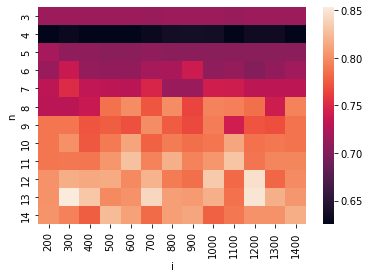

In [64]:
sns.heatmap(pivot_table)

plt.show()

The lighter the square the better the accuracy. beste variable has stored our best model and accuracy. 

In [65]:
beste

(0.8537037037037037,
     title  FIDE  blitz  bullet pred_title
 0      IM  2453   2819    2968         IM
 1      NM  2375   2659    2662         IM
 2      IM  2376   2595    2431         IM
 3      GM  2680   2728    2512         GM
 4      IM  2443   2563    2640         IM
 ..    ...   ...    ...     ...        ...
 667    NM  2100   2344    2431         NM
 668    NM  2106   2216    1913         NM
 669    NM  2126   2276    2259         NM
 670    NM  2119   2310    2203         NM
 671    NM  1988   2205    2064         NM
 
 [540 rows x 5 columns],
 KMeans(n_clusters=13))

We have a high amount of clusters at a decent amount iterations as our best result. This is a sensible result.

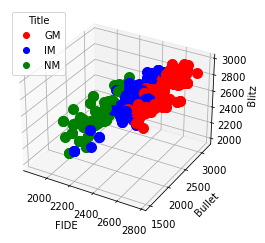

In [66]:
colors = {'GM': 'red', 'IM': 'blue', 'NM': 'green'}

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(beste[1])):
    row = beste[1].iloc[i]
    ax.scatter(row['FIDE'], row['bullet'], row['blitz'], c=colors[row['title']], s=100)
ax.set_xlabel('FIDE')
ax.set_ylabel('Bullet')
ax.set_zlabel('Blitz')


handles = [plt.plot([], [], marker='o', ls="", color=color, label=title)[0] for title, color in colors.items()]
ax.legend(handles=handles, title='Title', loc='upper left')

# https://stackoverflow.com/questions/31303912/matplotlib-pyplot-scatterplot-legend-from-color-dictionary
# How to get the legend with the colors

plt.show()

We can see we have a much better Seperation now, aswell as a good accuracy. 
For the future one could look into a different approach of classification, as this problem presents a very hard problem for unsupervised learning. An SVM could be good here, I wanted to test KMeans though as I was interested in how it would fair here. 